In [61]:
import sys
sys.path.append('..')

from swarm_algo.aco import AntColonyOptimizer
from search_algo.astar import AStar, TSPProblem as AStarTSPProblem
from search_algo.hill_climbing import HillClimbing, TSPProblem as HillClimbingTSPProblem
from search_algo.genetic import GeneticAlgorithm

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time
import warnings
from typing import List, Tuple, Dict
import pandas as pd


warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 10)
plt.rcParams['font.size'] = 10

## 1. Tải dữ liệu kiểm tra TSP

In [62]:
import os
import glob

def load_distance_matrix(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()
    
    matrix = []
    for line in lines:
        row = [int(x) for x in line.strip().split()]
        if row:
            matrix.append(row)
    
    return np.array(matrix)

def load_optimal_solution(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()
    
    solution = []
    for line in lines:
        line = line.strip()
        if line:
            solution.append(int(line) - 1)
    
    return solution[:-1] if solution else []

def calculate_tour_distance_from_matrix(tour, distance_matrix):
    from_cities = np.array(tour)
    to_cities = np.array(tour[1:] + [tour[0]])
    return np.sum(distance_matrix[from_cities, to_cities])

def load_all_test_cases():
    test_cases = {}
    data_dir = '../data/tsp'
    
    distance_files = sorted(glob.glob(os.path.join(data_dir, '*_d.txt')))
    
    for dist_file in distance_files:
        base_name = os.path.basename(dist_file).replace('_d.txt', '')
        sol_file = dist_file.replace('_d.txt', '_s.txt')
        
        distance_matrix = load_distance_matrix(dist_file)
        optimal_solution = load_optimal_solution(sol_file) if os.path.exists(sol_file) else None
        
        if optimal_solution:
            optimal_distance = calculate_tour_distance_from_matrix(optimal_solution, distance_matrix)
        else:
            optimal_distance = None
        
        test_cases[base_name] = {
            'distance_matrix': distance_matrix,
            'optimal_solution': optimal_solution,
            'optimal_distance': optimal_distance,
            'n_cities': len(distance_matrix)
        }
    
    return test_cases

test_cases = load_all_test_cases()


## 2. Hàm chạy thuật toán

In [63]:
def run_aco(distance_matrix, num_runs=5):
    n_cities = len(distance_matrix)
    results = []
    
    for _ in range(num_runs):
        cities_coords = np.random.rand(n_cities, 2) * 100
        
        aco = AntColonyOptimizer(
            colony=cities_coords,
            num_ant=20,
            iter=100,
            alpha=1.0,
            beta=2.0,
            rho=0.5,
            Q=100
        )
        
        aco.distance_matrix = distance_matrix
        aco.zeta = np.where(distance_matrix > 0, 1.0 / distance_matrix, 0)
        
        start_time = time.time()
        tour, distance = aco.run(verbose=False)
        elapsed_time = time.time() - start_time
        
        results.append({
            'tour': tour,
            'distance': distance,
            'time': elapsed_time
        })
    
    return results

def run_astar(distance_matrix, num_runs=1):
    n_cities = len(distance_matrix)
    results = []
    
    for _ in range(num_runs):
        cities_coords = [(0, 0) for _ in range(n_cities)]
        
        astar_problem = AStarTSPProblem(cities=cities_coords, start_city=0)
        astar_problem.distances = distance_matrix.tolist()
        astar_solver = AStar(problem=astar_problem, verbose=False)
        
        start_time = time.time()
        try:
            astar_path, astar_distance = astar_solver.solve()
            elapsed_time = time.time() - start_time
            
            if astar_path is not None:
                astar_tour = [state[0] for state in astar_path[:-1]]
                results.append({
                    'tour': astar_tour,
                    'distance': astar_distance,
                    'time': elapsed_time
                })
            else:
                results.append({
                    'tour': None,
                    'distance': float('inf'),
                    'time': elapsed_time
                })
        except Exception as e:
            elapsed_time = time.time() - start_time
            results.append({
                'tour': None,
                'distance': float('inf'),
                'time': elapsed_time
            })
    
    return results

def run_hill_climbing(distance_matrix, num_runs=5):
    results = []
    
    for _ in range(num_runs):
        hc_problem = HillClimbingTSPProblem(distance_matrix=distance_matrix)
        hc_solver = HillClimbing(problem=hc_problem, max_iters=1000, variant="steepest", verbose=False)
        
        start_time = time.time()
        tour, distance, _ = hc_solver.solve()
        elapsed_time = time.time() - start_time
        
        results.append({
            'tour': tour,
            'distance': distance,
            'time': elapsed_time
        })
    
    return results

def run_genetic_algorithm(distance_matrix, num_runs=5):
    results = []
    
    for _ in range(num_runs):
        ga = TSPGeneticAlgorithm(
            cities=None,
            distance_matrix=distance_matrix,
            population_size=50,
            mutation_rate=0.1,
            elite_rate=0.2
        )
        
        start_time = time.time()
        tour, distance, _, _ = ga.run(generations=100)
        elapsed_time = time.time() - start_time
        
        results.append({
            'tour': tour,
            'distance': distance,
            'time': elapsed_time
        })
    
    return results

In [64]:
class TSPGeneticAlgorithm:
    def __init__(self, cities, distance_matrix, population_size=50, mutation_rate=0.1, elite_rate=0.2):
        self.cities = cities
        self.distance_matrix = distance_matrix
        self.n_cities = len(distance_matrix)
        self.population_size = population_size
        self.mutation_rate = mutation_rate
        self.elite_rate = elite_rate
        
    def create_individual(self):
        tour = list(range(self.n_cities))
        np.random.shuffle(tour)
        return tour
    
    def calculate_fitness(self, tour):
        distance = calculate_tour_distance_from_matrix(tour, self.distance_matrix)
        return 1.0 / (1.0 + distance)
    
    def select_parents(self, population, fitness_scores):
        fitness_sum = np.sum(fitness_scores)
        selection_probs = fitness_scores / fitness_sum
        parent_indices = np.random.choice(len(population), size=2, p=selection_probs, replace=False)
        return population[parent_indices[0]], population[parent_indices[1]]
    
    def crossover(self, parent1, parent2):
        start = np.random.randint(0, self.n_cities - 1)
        end = np.random.randint(start + 1, self.n_cities)
        
        child = [-1] * self.n_cities
        child[start:end] = parent1[start:end]
        
        remaining = [city for city in parent2 if city not in child]
        idx = 0
        for i in range(self.n_cities):
            if child[i] == -1:
                child[i] = remaining[idx]
                idx += 1
        
        return child
    
    def mutate(self, tour):
        if np.random.rand() < self.mutation_rate:
            i, j = np.random.choice(self.n_cities, size=2, replace=False)
            tour[i], tour[j] = tour[j], tour[i]
        return tour
    
    def run(self, generations=100):
        population = [self.create_individual() for _ in range(self.population_size)]
        
        best_tour = None
        best_distance = float('inf')
        best_fitness_history = []
        avg_fitness_history = []
        
        for gen in range(generations):
            fitness_scores = np.array([self.calculate_fitness(ind) for ind in population])
            
            sorted_indices = np.argsort(-fitness_scores)
            population = [population[i] for i in sorted_indices]
            fitness_scores = fitness_scores[sorted_indices]
            
            current_best_tour = population[0]
            current_best_distance = calculate_tour_distance_from_matrix(current_best_tour, self.distance_matrix)
            
            if current_best_distance < best_distance:
                best_distance = current_best_distance
                best_tour = current_best_tour.copy()
            
            best_fitness_history.append(best_distance)
            avg_fitness_history.append(np.mean([calculate_tour_distance_from_matrix(t, self.distance_matrix) for t in population]))
            
            num_elites = int(self.elite_rate * self.population_size)
            next_generation = population[:num_elites]
            
            while len(next_generation) < self.population_size:
                parent1, parent2 = self.select_parents(population, fitness_scores)
                child = self.crossover(parent1, parent2)
                child = self.mutate(child)
                next_generation.append(child)
            
            population = next_generation
        
        return best_tour, best_distance, best_fitness_history, avg_fitness_history

## 3. Chạy tất cả thuật toán trên các bộ kiểm tra

In [65]:
all_results = {}

num_runs = 10

for test_name, test_data in test_cases.items():    
    distance_matrix = test_data['distance_matrix']
    
    all_results[test_name] = {
        'optimal_distance': test_data['optimal_distance'],
        'n_cities': test_data['n_cities']
    }
    
    print(f"  Chạy ACO ({num_runs} lần)...")
    all_results[test_name]['ACO'] = run_aco(distance_matrix, num_runs=num_runs)
    
    if test_data['n_cities'] <= 17:
        print(f"  Chạy A* ({num_runs} lần)...")
        all_results[test_name]['AStar'] = run_astar(distance_matrix, num_runs=num_runs)
    else:
        print(f"  Bỏ qua A* (quá nhiều thành phố: {test_data['n_cities']})")
        all_results[test_name]['AStar'] = []
    
    print(f"  Chạy Hill Climbing ({num_runs} lần)...")
    all_results[test_name]['HillClimbing'] = run_hill_climbing(distance_matrix, num_runs=num_runs)
    
    print(f"  Chạy Genetic Algorithm ({num_runs} lần)...")
    all_results[test_name]['GeneticAlgorithm'] = run_genetic_algorithm(distance_matrix, num_runs=num_runs)

  Chạy ACO (10 lần)...
  Chạy A* (10 lần)...
  Chạy Hill Climbing (10 lần)...
  Chạy Genetic Algorithm (10 lần)...
  Chạy ACO (10 lần)...
  Chạy A* (10 lần)...
  Chạy Hill Climbing (10 lần)...
  Chạy Genetic Algorithm (10 lần)...
  Chạy ACO (10 lần)...
  Bỏ qua A* (quá nhiều thành phố: 26)
  Chạy Hill Climbing (10 lần)...
  Chạy Genetic Algorithm (10 lần)...
  Chạy ACO (10 lần)...
  Bỏ qua A* (quá nhiều thành phố: 48)
  Chạy Hill Climbing (10 lần)...
  Chạy Genetic Algorithm (10 lần)...


## 4. Tính toán thống kê (Tốt nhất, Trung bình, Tệ nhất)

In [66]:
def calculate_statistics(results_list):
    if not results_list:
        return {
            'best': float('inf'),
            'worst': float('inf'),
            'average': float('inf'),
            'std': 0,
            'avg_time': 0
        }
    
    distances = [r['distance'] for r in results_list if r['distance'] != float('inf')]
    times = [r['time'] for r in results_list]
    
    if not distances:
        return {
            'best': float('inf'),
            'worst': float('inf'),
            'average': float('inf'),
            'std': 0,
            'avg_time': np.mean(times) if times else 0
        }
    
    return {
        'best': np.min(distances),
        'worst': np.max(distances),
        'average': np.mean(distances),
        'std': np.std(distances),
        'avg_time': np.mean(times)
    }

statistics = {}

for test_name, test_results in all_results.items():
    statistics[test_name] = {
        'optimal_distance': test_results['optimal_distance'],
        'n_cities': test_results['n_cities']
    }
    
    for algo in ['ACO', 'AStar', 'HillClimbing', 'GeneticAlgorithm']:
        if algo in test_results:
            statistics[test_name][algo] = calculate_statistics(test_results[algo])



for test_name in sorted(statistics.keys()):
    stats = statistics[test_name]
    
    print(f"\n{test_name} ({stats['n_cities']} thành phố) - Tối ưu: {stats['optimal_distance']}")
    print("-" * 120)
    
    data = []
    for algo in ['ACO', 'AStar', 'HillClimbing', 'GeneticAlgorithm']:
        if algo in stats:
            s = stats[algo]
            gap_best = ((s['best'] - stats['optimal_distance']) / stats['optimal_distance'] * 100) if stats['optimal_distance'] else 0
            gap_avg = ((s['average'] - stats['optimal_distance']) / stats['optimal_distance'] * 100) if stats['optimal_distance'] else 0
            
            data.append({
                'Thuật toán': algo,
                'Tốt nhất': f"{s['best']:.2f}",
                'Trung bình': f"{s['average']:.2f}",
                'Tệ nhất': f"{s['worst']:.2f}",
                'Độ lệch chuẩn': f"{s['std']:.2f}",
                'Chênh lệch TB (%)': f"{gap_best:.2f}",
                'Chênh lệch TB (%)': f"{gap_avg:.2f}",
                'Thời gian TB (s)': f"{s['avg_time']:.3f}"
            })
    
    df = pd.DataFrame(data)
    print(df.to_string(index=False))


p01 (15 thành phố) - Tối ưu: 291
------------------------------------------------------------------------------------------------------------------------
      Thuật toán Tốt nhất Trung bình Tệ nhất Độ lệch chuẩn Chênh lệch TB (%) Thời gian TB (s)
             ACO   291.00     291.00  291.00          0.00              0.00            0.373
           AStar   291.00     291.00  291.00          0.00              0.00            2.748
    HillClimbing   291.00     300.00  331.00         14.84              3.09            0.004
GeneticAlgorithm   291.00     315.40  335.00         18.24              8.38            0.137

p02 (17 thành phố) - Tối ưu: 2006
------------------------------------------------------------------------------------------------------------------------
      Thuật toán Tốt nhất Trung bình Tệ nhất Độ lệch chuẩn Chênh lệch TB (%) Thời gian TB (s)
             ACO  2085.00    2089.40 2115.00          9.15              4.16            0.395
           AStar  2085.00    20

## 5. Thống kê tổng hợp trên tất cả các bộ kiểm tra

In [67]:
aggregated_stats = {}

for algo in ['ACO', 'AStar', 'HillClimbing', 'GeneticAlgorithm']:
    gaps_best = []
    gaps_avg = []
    gaps_worst = []
    times = []
    
    for test_name, stats in statistics.items():
        if algo in stats and stats['optimal_distance'] is not None:
            s = stats[algo]
            if s['best'] != float('inf'):
                gaps_best.append((s['best'] - stats['optimal_distance']) / stats['optimal_distance'] * 100)
                gaps_avg.append((s['average'] - stats['optimal_distance']) / stats['optimal_distance'] * 100)
                gaps_worst.append((s['worst'] - stats['optimal_distance']) / stats['optimal_distance'] * 100)
                times.append(s['avg_time'])
    
    if gaps_best:
        aggregated_stats[algo] = {
            'gap_best_avg': np.mean(gaps_best),
            'gap_avg_avg': np.mean(gaps_avg),
            'gap_worst_avg': np.mean(gaps_worst),
            'gap_best_std': np.std(gaps_best),
            'gap_avg_std': np.std(gaps_avg),
            'gap_worst_std': np.std(gaps_worst),
            'avg_time': np.mean(times),
            'std_time': np.std(times)
        }
    else:
        aggregated_stats[algo] = None

agg_data = []
for algo in ['ACO', 'AStar', 'HillClimbing', 'GeneticAlgorithm']:
    if aggregated_stats[algo] is not None:
        s = aggregated_stats[algo]
        agg_data.append({
            'Thuật toán': algo,
            'Chênh lệch TB tốt nhất (%)': f"{s['gap_best_avg']:.2f} ± {s['gap_best_std']:.2f}",
            'Chênh lệch TB trung bình (%)': f"{s['gap_avg_avg']:.2f} ± {s['gap_avg_std']:.2f}",
            'Chênh lệch TB tệ nhất (%)': f"{s['gap_worst_avg']:.2f} ± {s['gap_worst_std']:.2f}",
            'Thời gian TB (s)': f"{s['avg_time']:.3f} ± {s['std_time']:.3f}"
        })

agg_df = pd.DataFrame(agg_data)
print(agg_df.to_string(index=False))

      Thuật toán Chênh lệch TB tốt nhất (%) Chênh lệch TB trung bình (%) Chênh lệch TB tệ nhất (%) Thời gian TB (s)
             ACO                1.62 ± 1.69                  3.03 ± 3.32               4.27 ± 4.79    0.658 ± 0.352
           AStar                1.97 ± 1.97                  1.97 ± 1.97               1.97 ± 1.97   11.352 ± 8.604
    HillClimbing                1.44 ± 1.62                  3.99 ± 0.82              11.19 ± 3.38    0.081 ± 0.118
GeneticAlgorithm              31.01 ± 38.72                43.13 ± 46.00             54.12 ± 51.61    0.161 ± 0.024


## 6. Trực quan hóa thống kê

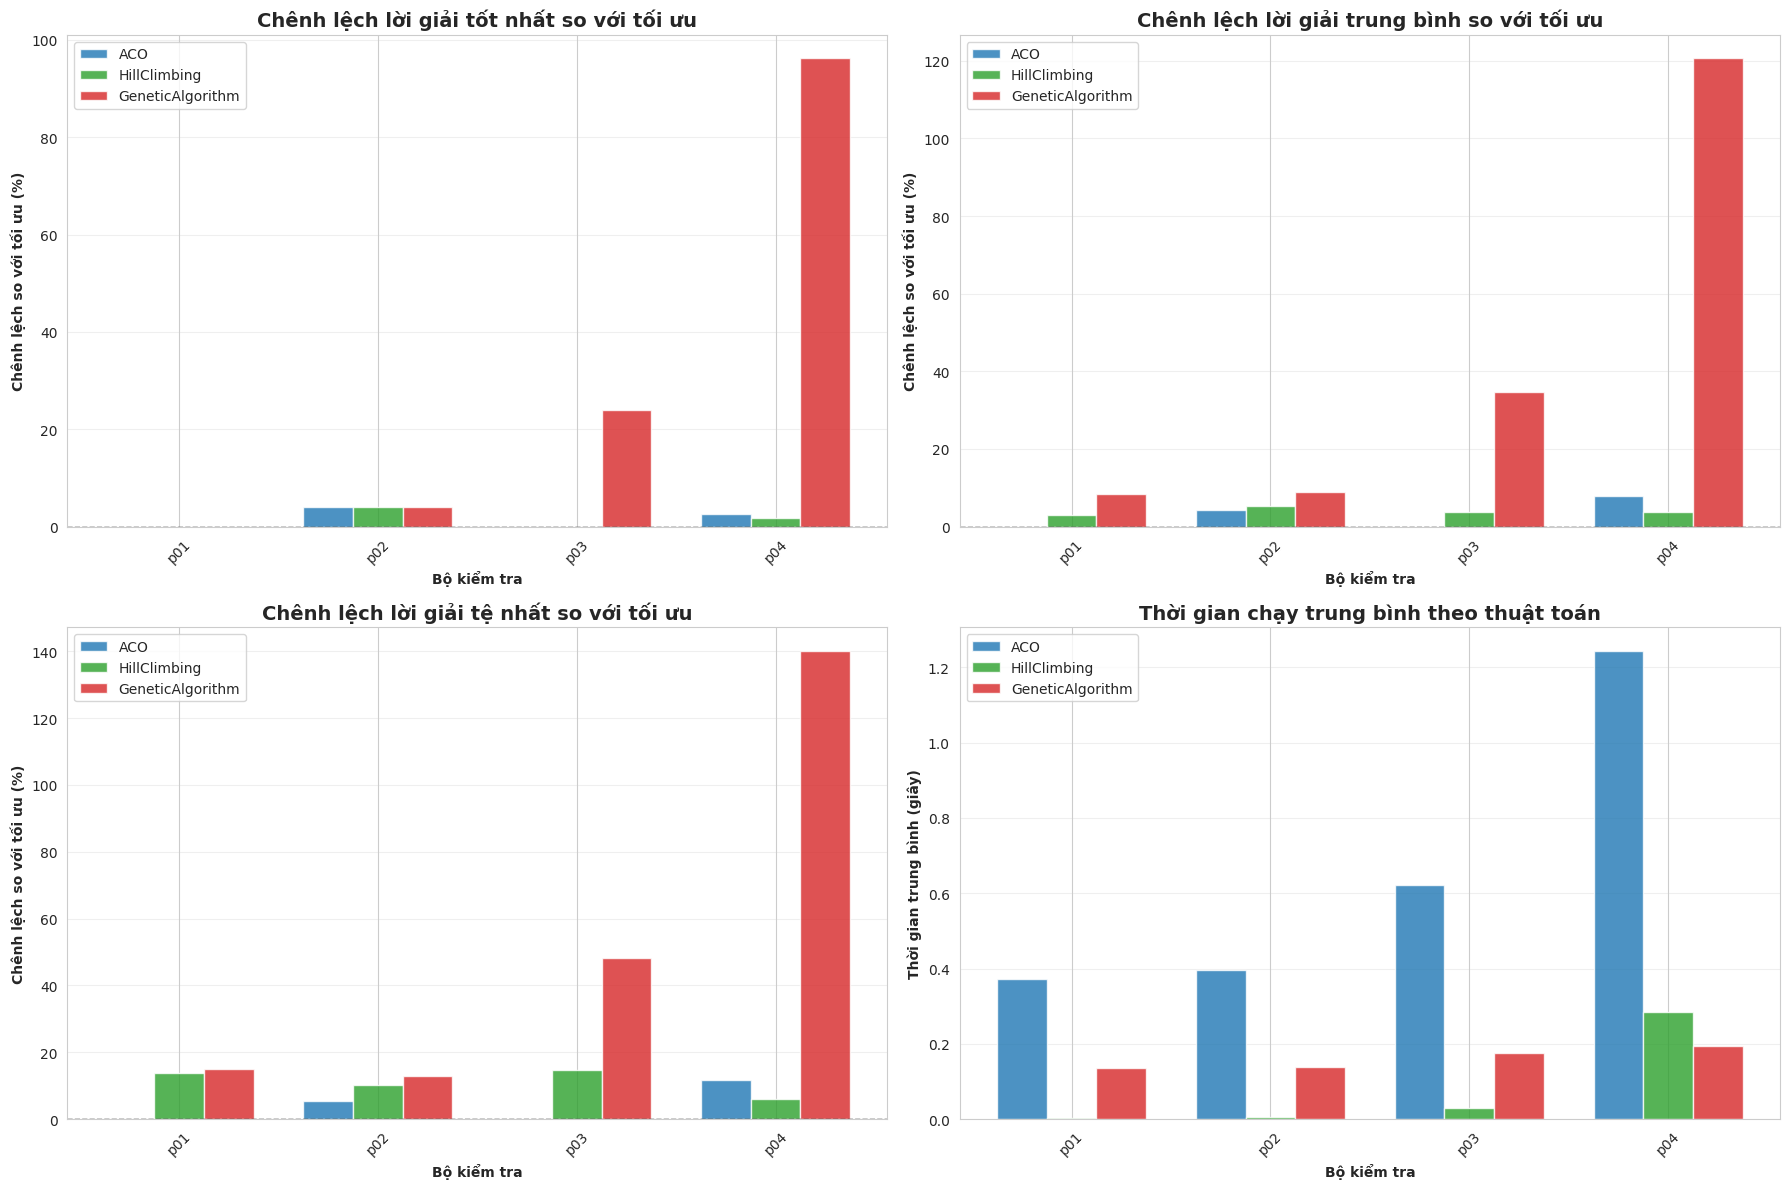

In [68]:
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

test_names = sorted(statistics.keys())
algorithms = ['ACO', 'HillClimbing', 'GeneticAlgorithm']
colors = {'ACO': '#1f77b4', 'AStar': '#ff7f0e', 'HillClimbing': '#2ca02c', 'GeneticAlgorithm': '#d62728'}

ax = axes[0, 0]
width = 0.25
x = np.arange(len(test_names))

for idx, algo in enumerate(algorithms):
    best_vals = []
    for test_name in test_names:
        if algo in statistics[test_name]:
            s = statistics[test_name][algo]
            gap = ((s['best'] - statistics[test_name]['optimal_distance']) / 
                   statistics[test_name]['optimal_distance'] * 100)
            best_vals.append(gap)
        else:
            best_vals.append(0)
    
    ax.bar(x + idx * width, best_vals, width, label=algo, color=colors[algo], alpha=0.8)

ax.set_xlabel('Bộ kiểm tra', fontweight='bold')
ax.set_ylabel('Chênh lệch so với tối ưu (%)', fontweight='bold')
ax.set_title('Chênh lệch lời giải tốt nhất so với tối ưu', fontweight='bold', fontsize=14)
ax.set_xticks(x + width)
ax.set_xticklabels(test_names, rotation=45)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
ax.axhline(y=0, color='black', linestyle='--', linewidth=1)

ax = axes[0, 1]
for idx, algo in enumerate(algorithms):
    avg_vals = []
    for test_name in test_names:
        if algo in statistics[test_name]:
            s = statistics[test_name][algo]
            gap = ((s['average'] - statistics[test_name]['optimal_distance']) / 
                   statistics[test_name]['optimal_distance'] * 100)
            avg_vals.append(gap)
        else:
            avg_vals.append(0)
    
    ax.bar(x + idx * width, avg_vals, width, label=algo, color=colors[algo], alpha=0.8)

ax.set_xlabel('Bộ kiểm tra', fontweight='bold')
ax.set_ylabel('Chênh lệch so với tối ưu (%)', fontweight='bold')
ax.set_title('Chênh lệch lời giải trung bình so với tối ưu', fontweight='bold', fontsize=14)
ax.set_xticks(x + width)
ax.set_xticklabels(test_names, rotation=45)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
ax.axhline(y=0, color='black', linestyle='--', linewidth=1)

ax = axes[1, 0]
for idx, algo in enumerate(algorithms):
    worst_vals = []
    for test_name in test_names:
        if algo in statistics[test_name]:
            s = statistics[test_name][algo]
            gap = ((s['worst'] - statistics[test_name]['optimal_distance']) / 
                   statistics[test_name]['optimal_distance'] * 100)
            worst_vals.append(gap)
        else:
            worst_vals.append(0)
    
    ax.bar(x + idx * width, worst_vals, width, label=algo, color=colors[algo], alpha=0.8)

ax.set_xlabel('Bộ kiểm tra', fontweight='bold')
ax.set_ylabel('Chênh lệch so với tối ưu (%)', fontweight='bold')
ax.set_title('Chênh lệch lời giải tệ nhất so với tối ưu', fontweight='bold', fontsize=14)
ax.set_xticks(x + width)
ax.set_xticklabels(test_names, rotation=45)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
ax.axhline(y=0, color='black', linestyle='--', linewidth=1)

ax = axes[1, 1]
for idx, algo in enumerate(algorithms):
    time_vals = []
    for test_name in test_names:
        if algo in statistics[test_name]:
            time_vals.append(statistics[test_name][algo]['avg_time'])
        else:
            time_vals.append(0)
    
    ax.bar(x + idx * width, time_vals, width, label=algo, color=colors[algo], alpha=0.8)

ax.set_xlabel('Bộ kiểm tra', fontweight='bold')
ax.set_ylabel('Thời gian trung bình (giây)', fontweight='bold')
ax.set_title('Thời gian chạy trung bình theo thuật toán', fontweight='bold', fontsize=14)
ax.set_xticks(x + width)
ax.set_xticklabels(test_names, rotation=45)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

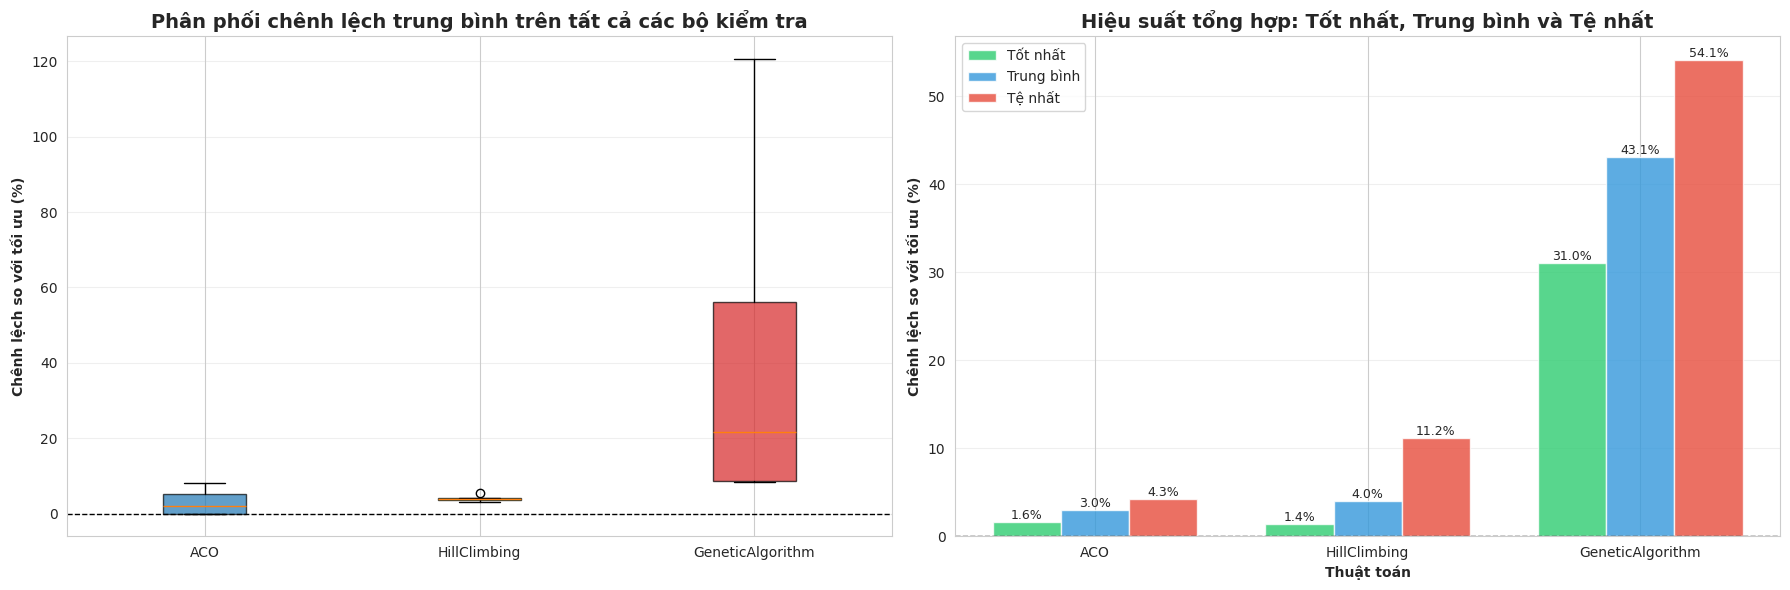

In [69]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

algorithms = ['ACO', 'HillClimbing', 'GeneticAlgorithm']

ax = axes[0]
box_data = []
labels = []

for algo in algorithms:
    for test_name in test_names:
        if algo in statistics[test_name]:
            s = statistics[test_name][algo]
            gap = ((s['average'] - statistics[test_name]['optimal_distance']) / 
                   statistics[test_name]['optimal_distance'] * 100)
            box_data.append(gap)
    labels.append(algo)

positions = [1, 2, 3]
bp = ax.boxplot([
    [((statistics[tn]['ACO']['average'] - statistics[tn]['optimal_distance']) / 
      statistics[tn]['optimal_distance'] * 100) for tn in test_names if 'ACO' in statistics[tn]],
    [((statistics[tn]['HillClimbing']['average'] - statistics[tn]['optimal_distance']) / 
      statistics[tn]['optimal_distance'] * 100) for tn in test_names if 'HillClimbing' in statistics[tn]],
    [((statistics[tn]['GeneticAlgorithm']['average'] - statistics[tn]['optimal_distance']) / 
      statistics[tn]['optimal_distance'] * 100) for tn in test_names if 'GeneticAlgorithm' in statistics[tn]]
], positions=positions, labels=algorithms, patch_artist=True)

for patch, color in zip(bp['boxes'], [colors[algo] for algo in algorithms]):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax.set_ylabel('Chênh lệch so với tối ưu (%)', fontweight='bold')
ax.set_title('Phân phối chênh lệch trung bình trên tất cả các bộ kiểm tra', fontweight='bold', fontsize=14)
ax.grid(True, alpha=0.3, axis='y')
ax.axhline(y=0, color='black', linestyle='--', linewidth=1)

ax = axes[1]
aggregated_gaps_best = []
aggregated_gaps_avg = []
aggregated_gaps_worst = []

for algo in algorithms:
    if aggregated_stats[algo]:
        aggregated_gaps_best.append(aggregated_stats[algo]['gap_best_avg'])
        aggregated_gaps_avg.append(aggregated_stats[algo]['gap_avg_avg'])
        aggregated_gaps_worst.append(aggregated_stats[algo]['gap_worst_avg'])

x_pos = np.arange(len(algorithms))
width = 0.25

bars1 = ax.bar(x_pos - width, aggregated_gaps_best, width, label='Tốt nhất', alpha=0.8, color='#2ecc71')
bars2 = ax.bar(x_pos, aggregated_gaps_avg, width, label='Trung bình', alpha=0.8, color='#3498db')
bars3 = ax.bar(x_pos + width, aggregated_gaps_worst, width, label='Tệ nhất', alpha=0.8, color='#e74c3c')

ax.set_ylabel('Chênh lệch so với tối ưu (%)', fontweight='bold')
ax.set_xlabel('Thuật toán', fontweight='bold')
ax.set_title('Hiệu suất tổng hợp: Tốt nhất, Trung bình và Tệ nhất', fontweight='bold', fontsize=14)
ax.set_xticks(x_pos)
ax.set_xticklabels(algorithms)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
ax.axhline(y=0, color='black', linestyle='--', linewidth=1)

for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

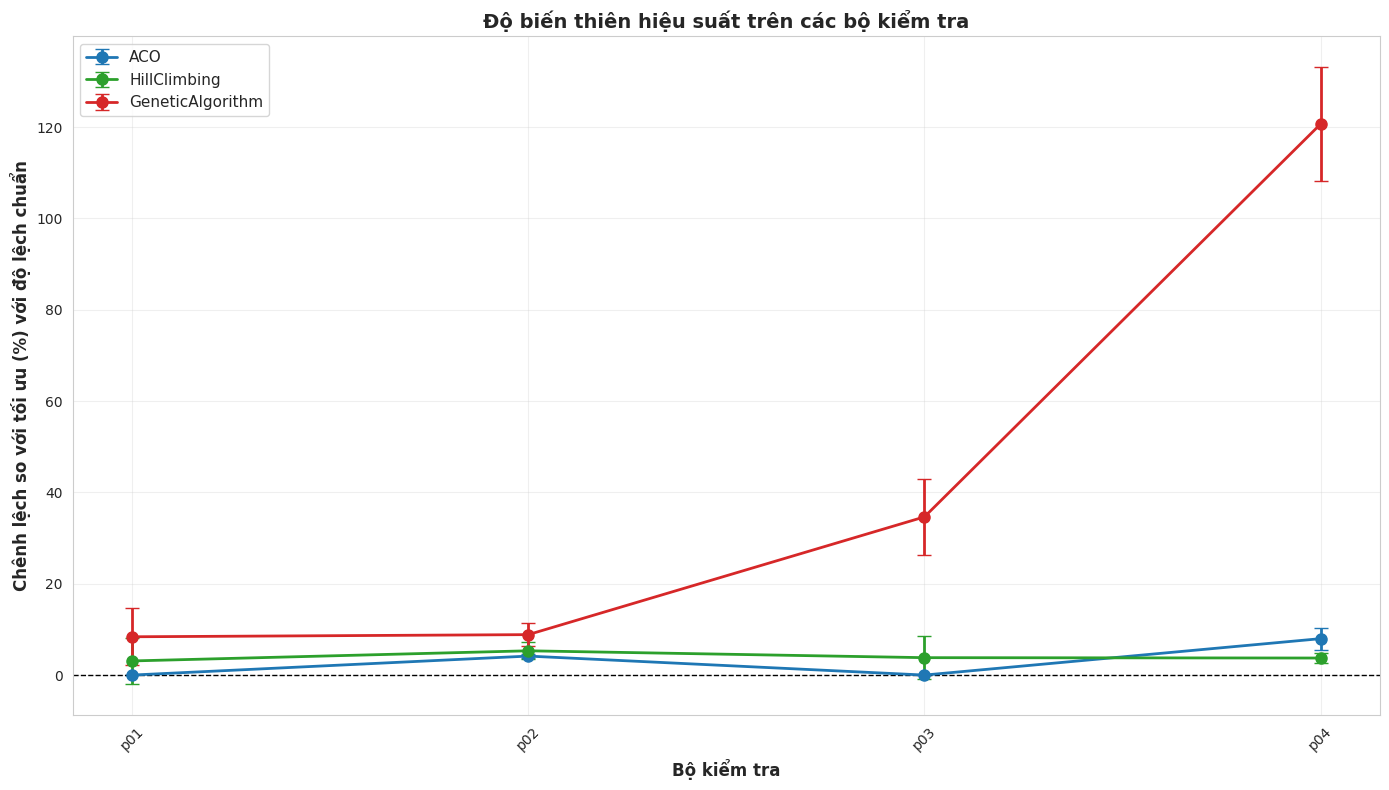

In [70]:
fig, ax = plt.subplots(1, 1, figsize=(14, 8))

for algo in algorithms:
    avg_gaps = []
    std_gaps = []
    
    for test_name in test_names:
        if algo in statistics[test_name]:
            s = statistics[test_name][algo]
            gap = ((s['average'] - statistics[test_name]['optimal_distance']) / 
                   statistics[test_name]['optimal_distance'] * 100)
            avg_gaps.append(gap)
            std_gap = (s['std'] / statistics[test_name]['optimal_distance'] * 100)
            std_gaps.append(std_gap)
    
    x_positions = np.arange(len(test_names))
    ax.errorbar(x_positions, avg_gaps, yerr=std_gaps, 
                label=algo, marker='o', markersize=8, 
                linewidth=2, capsize=5, color=colors[algo])

ax.set_xlabel('Bộ kiểm tra', fontweight='bold', fontsize=12)
ax.set_ylabel('Chênh lệch so với tối ưu (%) với độ lệch chuẩn', fontweight='bold', fontsize=12)
ax.set_title('Độ biến thiên hiệu suất trên các bộ kiểm tra', fontweight='bold', fontsize=14)
ax.set_xticks(np.arange(len(test_names)))
ax.set_xticklabels(test_names, rotation=45)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='black', linestyle='--', linewidth=1)

plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from math import pi

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))

categories = ['Chất lượng\ngiải pháp', 'Tốc độ', 'Độ ổn định', 'Khả năng\ntìm tối ưu']
N = len(categories)

def normalize_metric(value, min_val, max_val, inverse=False):
    if max_val == min_val:
        return 0.5
    if inverse:
        return 1 - (value - min_val) / (max_val - min_val)
    else:
        return (value - min_val) / (max_val - min_val)

algorithms = ['ACO', 'HillClimbing', 'GeneticAlgorithm']
algo_names_vi = {
    'ACO': 'ACO (Đàn kiến)',
    'HillClimbing': 'Hill Climbing (Leo đồi)',
    'GeneticAlgorithm': 'Thuật toán di truyền'
}

colors = {
    'ACO': '#1f77b4',
    'HillClimbing': '#2ca02c',
    'GeneticAlgorithm': '#d62728'
}

all_quality = []
all_speed = []
all_stability = []
all_best = []

for algo in algorithms:
    if aggregated_stats[algo]:
        all_quality.append(aggregated_stats[algo]['gap_avg_avg'])
        all_speed.append(aggregated_stats[algo]['avg_time'])
        all_stability.append(aggregated_stats[algo]['gap_avg_std'])
        all_best.append(aggregated_stats[algo]['gap_best_avg'])

angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

ax = plt.subplot(111, polar=True)

for algo in algorithms:
    if aggregated_stats[algo]:
        s = aggregated_stats[algo]
        
        quality_score = normalize_metric(s['gap_avg_avg'], min(all_quality), max(all_quality), inverse=True)
        speed_score = normalize_metric(s['avg_time'], min(all_speed), max(all_speed), inverse=True)
        stability_score = normalize_metric(s['gap_avg_std'], min(all_stability), max(all_stability), inverse=True)
        best_score = normalize_metric(s['gap_best_avg'], min(all_best), max(all_best), inverse=True)
        
        values = [quality_score, speed_score, stability_score, best_score]
        values += values[:1]
        
        ax.plot(angles, values, 'o-', linewidth=2, label=algo_names_vi[algo], color=colors[algo])
        ax.fill(angles, values, alpha=0.15, color=colors[algo])

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, size=11, fontweight='bold')
ax.set_ylim(0, 1)
ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels(['0.2', '0.4', '0.6', '0.8', '1.0'], size=9)
ax.grid(True, linestyle='--', alpha=0.7)

plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=11)
plt.title('So sánh hiệu suất thuật toán\n(Biểu đồ radar - Chỉ số chuẩn hóa)', 
          size=14, fontweight='bold', pad=30)

plt.tight_layout()
plt.show()

print("\nGiải thích các chỉ số:")
print("=" * 80)
print("- Chất lượng giải pháp: Dựa trên chênh lệch trung bình so với tối ưu (thấp hơn = tốt hơn)")
print("- Tốc độ: Dựa trên thời gian chạy trung bình (nhanh hơn = tốt hơn)")
print("- Độ ổn định: Dựa trên độ lệch chuẩn (ổn định hơn = tốt hơn)")
print("- Khả năng tìm tối ưu: Dựa trên chênh lệch giải pháp tốt nhất (gần tối ưu hơn = tốt hơn)")
print("\nGiá trị càng gần 1.0 (rìa ngoài) = Hiệu suất càng tốt")
print("=" * 80)

## 7. Tổng kết và kết luận

In [71]:
print("\n" + "=" * 100)
print("TỔNG KẾT SO SÁNH CÁC THUẬT TOÁN")
print("=" * 100)

print(f"\nTổng số bộ kiểm tra đã đánh giá: {len(test_cases)}")
print(f"Số lần chạy cho mỗi thuật toán: {num_runs}")

print("\n" + "-" * 100)
print("CÁC PHÁT HIỆN CHÍNH:")
print("-" * 100)

if aggregated_stats['ACO']:
    print(f"\nACO (Tối ưu hóa Đàn kiến):")
    print(f"  - Chênh lệch trung bình so với tối ưu: {aggregated_stats['ACO']['gap_avg_avg']:.2f}%")
    print(f"  - Chênh lệch giải pháp tốt nhất: {aggregated_stats['ACO']['gap_best_avg']:.2f}%")
    print(f"  - Chênh lệch giải pháp tệ nhất: {aggregated_stats['ACO']['gap_worst_avg']:.2f}%")
    print(f"  - Thời gian chạy trung bình: {aggregated_stats['ACO']['avg_time']:.3f}s")

if aggregated_stats['HillClimbing']:
    print(f"\nHill Climbing (Leo đồi):")
    print(f"  - Chênh lệch trung bình so với tối ưu: {aggregated_stats['HillClimbing']['gap_avg_avg']:.2f}%")
    print(f"  - Chênh lệch giải pháp tốt nhất: {aggregated_stats['HillClimbing']['gap_best_avg']:.2f}%")
    print(f"  - Chênh lệch giải pháp tệ nhất: {aggregated_stats['HillClimbing']['gap_worst_avg']:.2f}%")
    print(f"  - Thời gian chạy trung bình: {aggregated_stats['HillClimbing']['avg_time']:.3f}s")

if aggregated_stats['GeneticAlgorithm']:
    print(f"\nGenetic Algorithm (Thuật toán di truyền):")
    print(f"  - Chênh lệch trung bình so với tối ưu: {aggregated_stats['GeneticAlgorithm']['gap_avg_avg']:.2f}%")
    print(f"  - Chênh lệch giải pháp tốt nhất: {aggregated_stats['GeneticAlgorithm']['gap_best_avg']:.2f}%")
    print(f"  - Chênh lệch giải pháp tệ nhất: {aggregated_stats['GeneticAlgorithm']['gap_worst_avg']:.2f}%")
    print(f"  - Thời gian chạy trung bình: {aggregated_stats['GeneticAlgorithm']['avg_time']:.3f}s")

best_algo_by_quality = min(
    [(algo, aggregated_stats[algo]['gap_avg_avg']) 
     for algo in algorithms if aggregated_stats[algo]], 
    key=lambda x: x[1]
)

best_algo_by_speed = min(
    [(algo, aggregated_stats[algo]['avg_time']) 
     for algo in algorithms if aggregated_stats[algo]], 
    key=lambda x: x[1]
)

print("\n" + "-" * 100)
print("KHUYẾN NGHỊ:")
print("-" * 100)

print(f"\nTốt nhất về chất lượng giải pháp: {best_algo_by_quality[0]}")
print(f"  - Đạt {best_algo_by_quality[1]:.2f}% chênh lệch trung bình so với tối ưu")

print(f"\nTốt nhất về tốc độ: {best_algo_by_speed[0]}")
print(f"  - Thời gian chạy trung bình: {best_algo_by_speed[1]:.3f}s")

print("\n" + "-" * 100)
print("ĐặC ĐIểM CÁC THUẬT TOÁN:")
print("-" * 100)

characteristics = {
    'ACO': [
        'Trí tuệ đàn lấy cảm hứng từ hành vi kiếm ăn của kiến',
        'Cân bằng tốt giữa khai thác và thăm dò',
        'Vết mùi pheromone giúp thoát khỏi tối ưu cục bộ',
        'Phù hợp với các bài toán tối ưu động và phức tạp'
    ],
    'HillClimbing': [
        'Thuật toán tìm kiếm cục bộ đơn giản',
        'Hội tụ nhanh nhưng dễ rơi vào tối ưu cục bộ',
        'Hiệu suất phụ thuộc nhiều vào giải pháp ban đầu',
        'Tốt nhất cho các giải pháp xấp xỉ nhanh'
    ],
    'GeneticAlgorithm': [
        'Phương pháp tiến hóa dựa trên quần thể',
        'Duy trì tính đa dạng thông qua lai ghép và đột biến',
        'Khám phá không gian tìm kiếm tốt',
        'Có thể thoát khỏi tối ưu cục bộ hiệu quả'
    ]
}

for algo, chars in characteristics.items():
    print(f"\n{algo}:")
    for char in chars:
        print(f"  - {char}")

print("\n" + "=" * 100)


TỔNG KẾT SO SÁNH CÁC THUẬT TOÁN

Tổng số bộ kiểm tra đã đánh giá: 4
Số lần chạy cho mỗi thuật toán: 10

----------------------------------------------------------------------------------------------------
CÁC PHÁT HIỆN CHÍNH:
----------------------------------------------------------------------------------------------------

ACO (Tối ưu hóa Đàn kiến):
  - Chênh lệch trung bình so với tối ưu: 3.03%
  - Chênh lệch giải pháp tốt nhất: 1.62%
  - Chênh lệch giải pháp tệ nhất: 4.27%
  - Thời gian chạy trung bình: 0.658s

Hill Climbing (Leo đồi):
  - Chênh lệch trung bình so với tối ưu: 3.99%
  - Chênh lệch giải pháp tốt nhất: 1.44%
  - Chênh lệch giải pháp tệ nhất: 11.19%
  - Thời gian chạy trung bình: 0.081s

Genetic Algorithm (Thuật toán di truyền):
  - Chênh lệch trung bình so với tối ưu: 43.13%
  - Chênh lệch giải pháp tốt nhất: 31.01%
  - Chênh lệch giải pháp tệ nhất: 54.12%
  - Thời gian chạy trung bình: 0.161s

------------------------------------------------------------------------